In [1]:
# %pip install numpy
# %pip install opencv-python
# %pip install matplotlib

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import statistics
import collections

<h3> Display Image Functions </h3>

In [3]:
def show(img_input, name):
    plt.figure(figsize = (15,15))
    plt.axis("off")
    plt.title(name)
    plt.imshow(img_input)
    plt.show()

def show_multiple(img_input, names):
    plt.figure(figsize = (10*len(names),10))
    n = len(names)
    for i in range(n):
        plt.subplot(1, n, 1 + i)
        plt.axis("off")
        plt.title(names[i])
        plt.imshow(img_input[i])
    plt.tight_layout()
    plt.show()

def show_gray(img_input, name):
    plt.figure(figsize = (15,15))
    plt.axis("off")
    plt.title(name)
    plt.imshow(img_input, cmap='gray')
    plt.show()

def show_multiple_gray(img_input, names):
    plt.figure(figsize = (10*len(names),10))
    n = len(names)
    for i in range(n):
        plt.subplot(1, n, 1 + i)
        plt.axis("off")
        plt.title(names[i])
        plt.imshow(img_input[i], cmap='gray')
    plt.tight_layout()
    plt.show()

def show_multiple_mix(img_input, names, gray):
    plt.figure(figsize = (10*len(names),10))
    n = len(names)
    for i in range(n):
        plt.subplot(1, n, 1 + i)
        plt.axis("off")
        plt.title(names[i])
        if(gray[i]):
            plt.imshow(img_input[i], cmap='gray')
        else:
            plt.imshow(img_input[i])
    plt.tight_layout()
    plt.show()

<h3>Show Original and Grayscale Puzzle Image</h3>

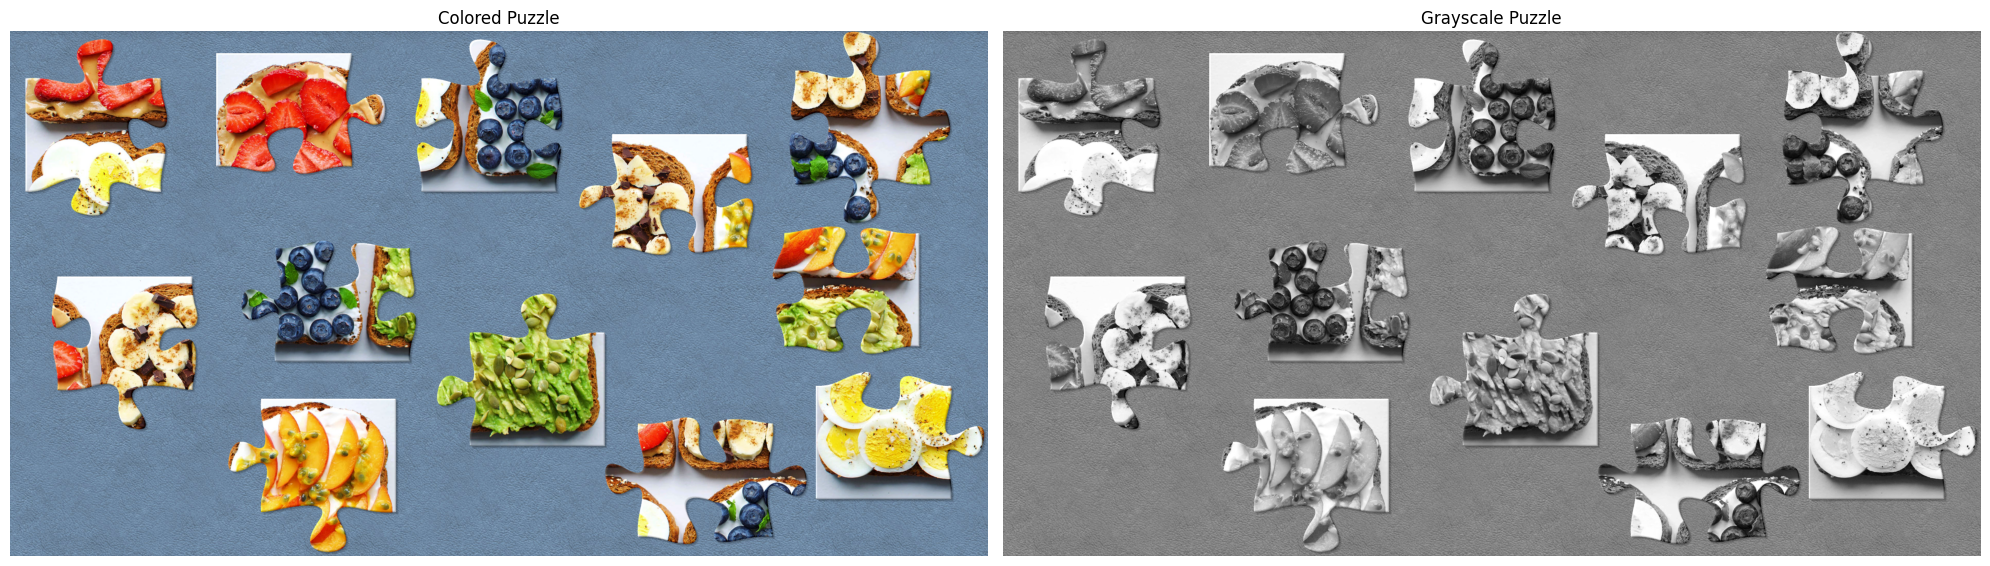

In [4]:

path = 'puzzles/sandwiches.png'
img_orig = cv2.imread(path, 1)
img_color = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY)

show_multiple_mix([img_color, gray], ["Colored Puzzle", "Grayscale Puzzle"], [False, True])

<h3>Remove background by removing the most frequent "colors" in RGB domain and changing image to black and white</h3>

In [5]:
#Colored Image
def remove_background(img_input, thresh):
    max = [0, 0, 0]
    std = [0, 0, 0]
    color_img_array = np.array(img_input)
    color = [color_img_array[:,:,0].flatten(), color_img_array[:,:,1].flatten(), color_img_array[:,:,2].flatten()]
    c = ('r','g','b')
    for i, col in enumerate(color):
        histr, _ = np.histogram(col, bins=256, range=[0, 256])
        max[i] = histr.argmax()
        std[i] = np.std(col.flatten(), axis = 0)
    img_input = img_input.astype(int)
    stddev = [int(x*thresh) for x in std]
    for i in range(img_input.shape[0]):
        for j in range(img_input.shape[1]):
            changed = False
            pixel = img_input[i][j]
            if max[0] - stddev[0] < pixel[0] and pixel[0] <  max[0]+stddev[0]:
                if max[1] - stddev[1] < pixel[1] and pixel[1] <  max[1]+stddev[1]:
                    if max[2] - stddev[2] < pixel[2] and pixel[2] <  max[2]+stddev[2]:
                        img_input[i][j] = [0, 0, 0]
                        changed = True
            if not changed:
                img_input[i][j] = [255, 255, 255]
                
    return img_input
#Grayscale Image
def remove_gray_background(img_input, thresh):
    max = 0
    std = 0
    color = np.array(img_input)
    histr, _ = np.histogram(color, bins=256, range=[0, 256])
    max = histr.argmax()
    img_input = img_input.astype(int)
    stddev = std*thresh
    for i in range(img_input.shape[0]):
        for j in range(img_input.shape[1]):
            changed = False
            if max - stddev < img_input[i][j] and img_input[i][j] <  max+stddev:
                img_input[i][j] = 0
                changed = True
                        
            if not changed:
                img_input[i][j] = 255
    return img_input

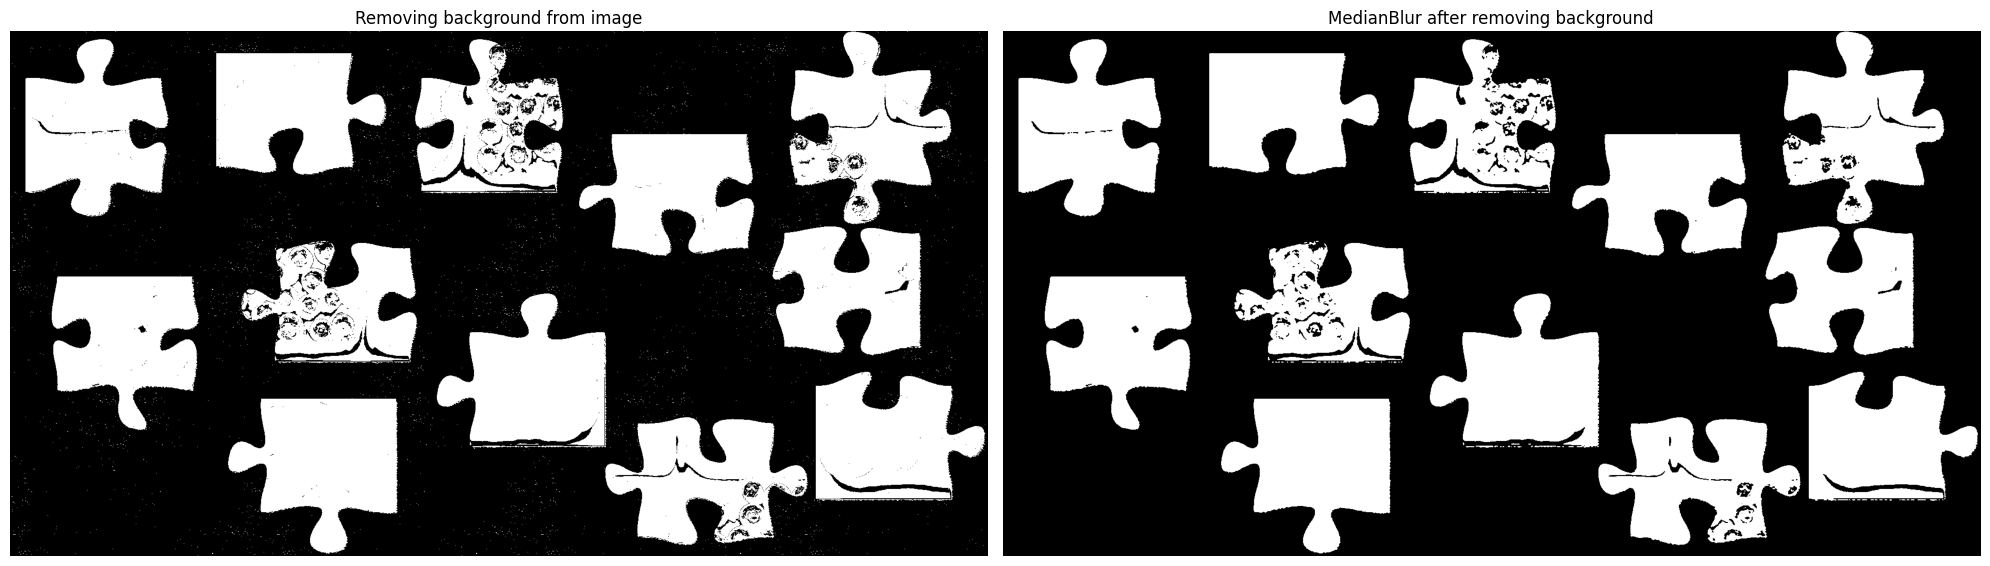

In [6]:
img_bg_removed = np.copy(img_color)
img_bg_removed = remove_background(img_bg_removed, 0.75)
img_bg_removed = img_bg_removed.astype(np.uint8)
img_median = cv2.medianBlur(img_bg_removed, 3)
show_multiple_gray([img_bg_removed, img_median], ["Removing background from image", "MedianBlur after removing background"])

<h3>Testing Out Canny Edge Detection</h3>

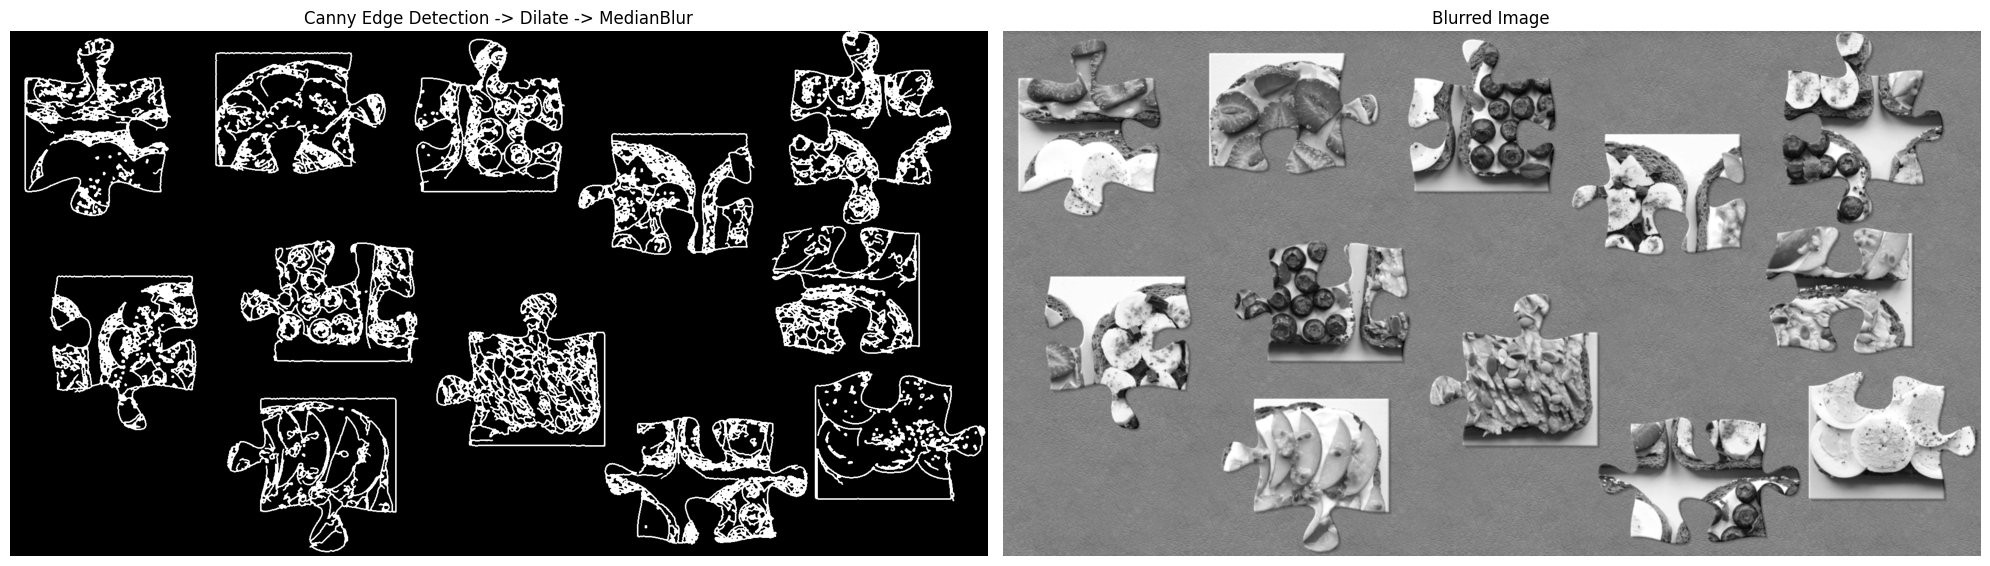

In [7]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
img_blur = cv2.GaussianBlur(gray, (3, 3), 0)
cannyedges = cv2.Canny(image=img_blur, threshold1=70, threshold2=200)
cannyedges = cv2.dilate(cannyedges, kernel)
cannyedges = cv2.medianBlur(cannyedges, 3)
show_multiple_mix([cannyedges, img_blur], ["Canny Edge Detection -> Dilate -> MedianBlur", "Blurred Image"], [True, True])
# show_gray(edges, "Canny Edge Detection -> Dilate -> MedianBlur")

<h3>Mixing Canny Edge Detection and BG removal</h3>

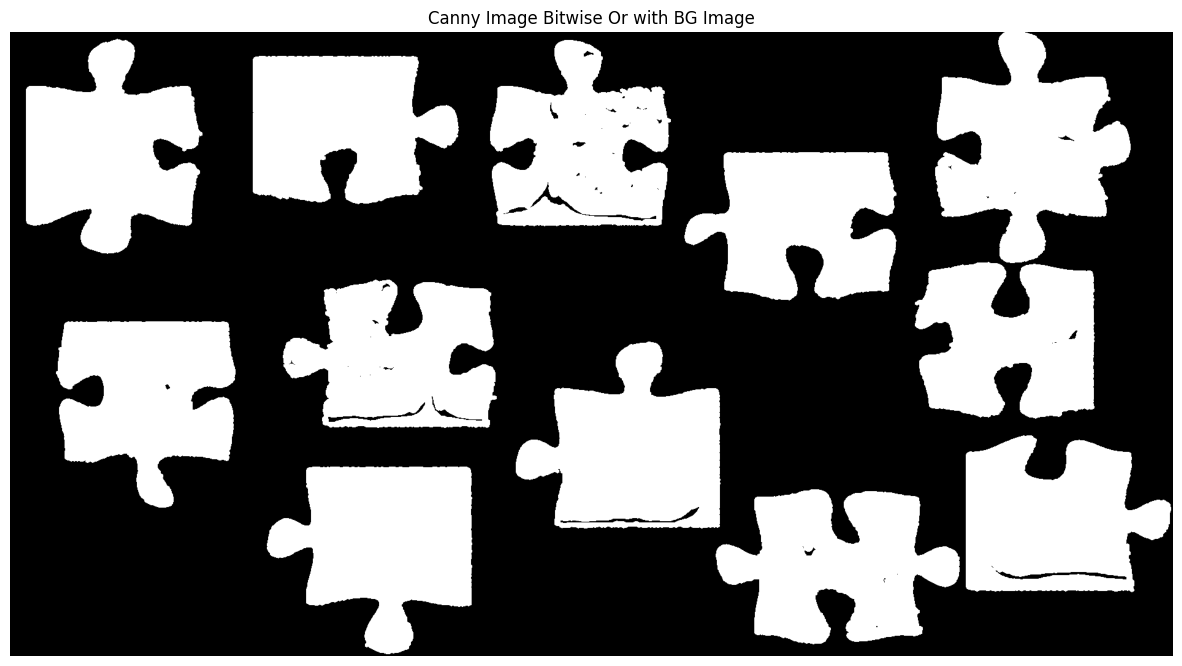

In [11]:
canny_bg_img = np.copy(img_median)
edges = np.copy(cannyedges)
for x in range(canny_bg_img.shape[0]):
    for y in range(canny_bg_img.shape[1]):
        if edges[x][y] != 0:
            canny_bg_img[x][y] = [255, 255, 255]
canny_bg_img = cv2.cvtColor(canny_bg_img, cv2.COLOR_BGR2GRAY)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
canny_bg_img = cv2.dilate(canny_bg_img, kernel)
show_gray(canny_bg_img, "Canny Image Bitwise Or with BG Image")

<h3>Assuming the corner pixel will always contain the background</h3>

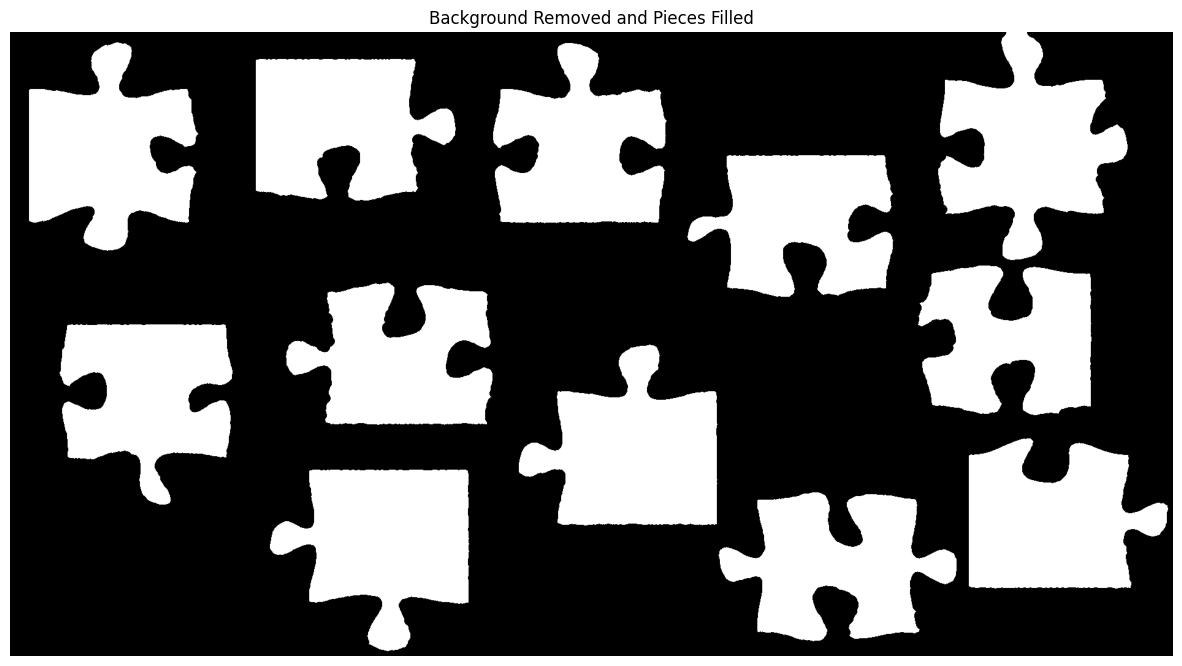

In [22]:
def get_background(is_background, img_compare):
    q = collections.deque([(0, 0)])
    visited = set((0, 0))
    dir = [(0, 1), (0, -1), (1, 0), (-1, 0)]
    l, w = is_background.shape
    while q:
        x, y = q.popleft()
        is_background[x][y] = 1
        for dx, dy in dir:
            if -1 < x + dx and x + dx < l and -1 < y + dy and y + dy < w:
                if (img_compare[x+dx][y+dy] == 0).any():
                    if (x + dx, y + dy) not in visited:
                        q.append((x + dx, y + dy))
                        visited.add((x + dx, y + dy))
    return is_background

def fill_img(background, image):
    for x in range(background.shape[0]):
            for y in range(background.shape[1]):
                if not background[x][y]:
                    image[x][y] = 255
    return image

#get background of canny image + bg image
is_bg = get_background(np.zeros_like(np.array(cannyedges)), canny_bg_img)
filled_pieces = fill_img(is_bg, canny_bg_img)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
filled_pieces = cv2.dilate(filled_pieces, kernel)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (17,17))
filled_pieces = cv2.erode(filled_pieces, kernel)
show_gray(filled_pieces, "Background Removed and Pieces Filled")


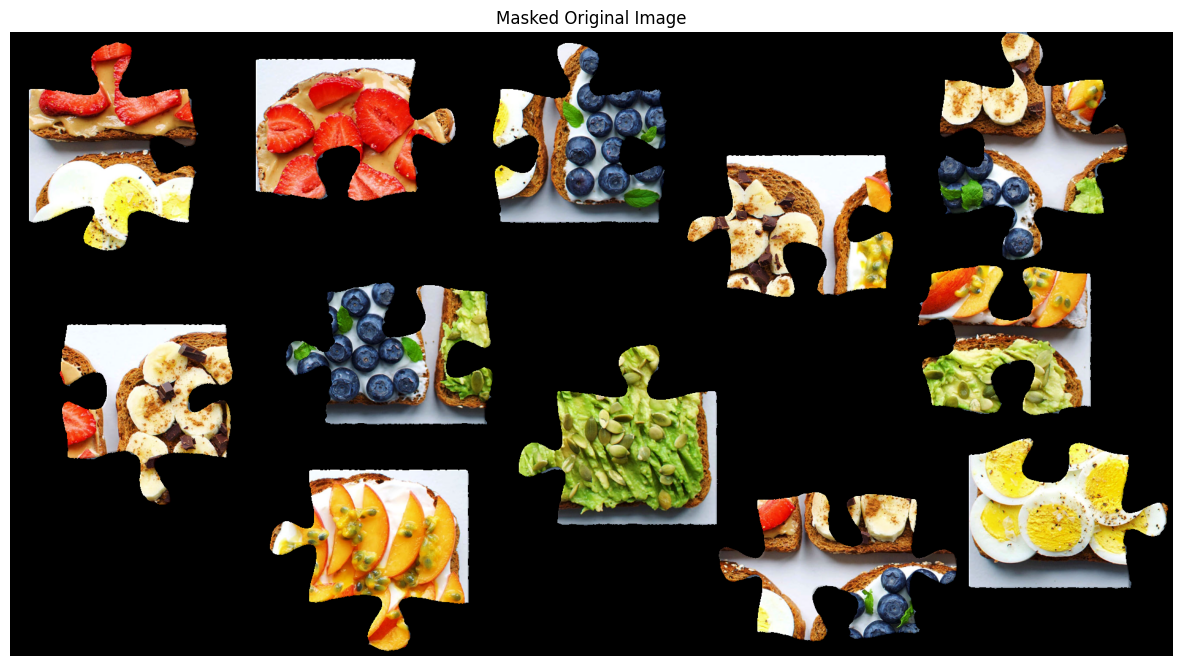

In [26]:
# img_array = cv2.imread('./puzzles/sandwiches.png')
img_seperated = np.copy(img_orig)
filled_pieces = np.copy(filled_pieces)
for x in range(img_seperated.shape[0]):
    for y in range(img_seperated.shape[1]):
        if filled_pieces[x][y] == 0:
            img_seperated[x][y] = [0, 0, 0]
img_seperated = cv2.cvtColor(img_seperated, cv2.COLOR_BGR2RGB)
show(img_seperated, "Masked Original Image")

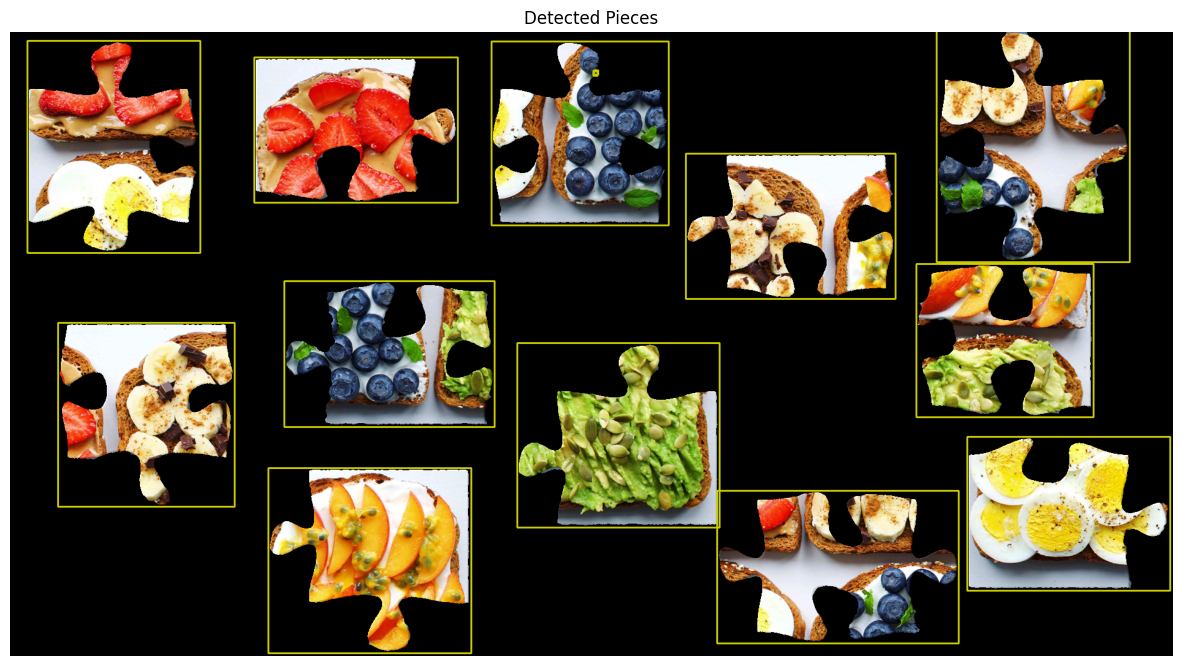

In [32]:
def detect_objects(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary_image = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw bounding boxes around each detected object
    img_with_boxes = np.copy(image)
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(img_with_boxes, (x-3, y-3), (x + w + 3, y + h + 3), (204, 204, 0), 2)

    return img_with_boxes

# Example usage:
image_pieces_detected = detect_objects(img_seperated)

# Display the result
show(image_pieces_detected, "Detected Pieces")